In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import keras
import tensorflow
from keras import Sequential
from keras.layers import Dense

In [188]:
df = pd.read_csv('COVID19_open_line_list.csv')

In [189]:
df = df[pd.notnull(df['age'])]
df = df[pd.notnull(df['sex'])]
df = df[pd.notnull(df['country'])]
df = df[pd.notnull(df['lives_in_Wuhan'])]
df.drop(columns = ['city','province','latitude','longitude','geo_resolution','additional_information','source','sequence_available','outcome','notes_for_discussion','location','admin3','admin2','admin1','country_new','admin_id','data_moderator_initials'])

,ID,age,sex,country,wuhan(0)_not_wuhan(1),date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,chronic_disease_binary,chronic_disease,date_death_or_discharge
258,11545,70-79,male,Japan,1,19.02.2020,20.02.2020,21.02.2020,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN
276,1771,60-69,male,Japan,1,14.01.2020,25.01.2020,28.01.2020,"chills, cough, joint pain",no,NaN,NaN,no,NaN,NaN,NaN
277,2594,60-69,male,Australia,1,23.01.2020,NaN,29.01.2020,NaN,no,NaN,Wuhan,NaN,NaN,NaN,NaN
278,3021,60-69,male,United States,1,NaN,NaN,30.01.2020,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN
287,11547,60-69,male,Japan,1,06.02.2020,21.02.2020,21.02.2020,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1575,5108,5,female,China,1,22.01.2020,27.01.2020,02.02.2020,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN
1577,9191,4,female,China,1,NaN,NaN,08.02.2020,NaN,no,25.01.2020 -,Wuhan City,NaN,NaN,NaN,NaN
1579,2362,3,female,China,1,27.01.2020,27.01.2020,29.01.2020,NaN,no,21.01.2020,Wuhan,NaN,NaN,NaN,NaN
1580,163,2,female,China,1,22.01.2020,23.01.2020,24.01.2020,"fever, sneeze",yes,21.01.2020,Wuhan,NaN,NaN,NaN,NaN


In [190]:
test = df.iloc[:,13]
symptom_set = set()
for row in list(test):
    row = str(row)
    l = row.split(",")
    for symp in l:
        symp = symp.strip()
        if symp == "nan":
            continue
        elif symp not in symptom_set:
            if "fever" in symp or "Fever" in symp:
                symptom_set.add("fever")
            else:
                symptom_set.add(symp)
        else:
            continue
print(symptom_set)

{'pneumonitis', 'runny nose', 'muscular soreness', 'rigor', 'physical discomfort', 'vomiting', 'myalgias', 'myalgia', 'soreness', 'lesions on chest radiographs', 'lack of energy', 'pleural effusion', 'coughing', 'diarrhea', 'feeling ill', 'sneeze', 'other symptoms', 'pleuritic chest pain', 'chest tightness', 'pharyngeal discomfort', 'muscle ache', 'fatigue', 'weak', 'sore throat', 'muscle soreness', 'severe dyspnea', 'pharynx', 'headache', 'respiratory symptoms', 'expectoration', 'nasal congestion', 'sneezing', 'nausea', 'cough', 'muscular stiffness', 'chest distress', 'chest pain', 'rhinorrhoea', 'pharyngalgia', 'sore limbs', 'shortness of breath', 'sore muscle', 'dizziness', 'eye irritation', 'pneumonia', 'discomfort', 'fever', 'dyspnea', 'anhelation', 'eventually showed acute left heart failure and acute coronary syndrome', 'muscle aches', 'joint pain', 'flu-like symptoms', 'muscle pain', 'weakness', 'conjunctivitis', 'asymptomatic', 'dry cough', 'diarrhoea', 'sputum', 'chills', 'sw

In [191]:
test = df.iloc[:,5]
country_dict = dict()
count = 0
for row in list(test):
    row = str(row)
    if row in country_dict:
        continue
    else:
        country_dict[row] = count
        count+= 1
print(country_dict)

{'Japan': 0, 'Australia': 1, 'United States': 2, 'Canada': 3, 'Sweden': 4, 'Germany': 5, 'Finland': 6, 'China': 7, 'Singapore': 8, 'Thailand': 9, 'Vietnam': 10, 'South Korea': 11, 'Spain': 12, 'Cambodia': 13, 'North Macedonia': 14, 'Georgia': 15, 'France': 16, 'Philippines': 17, 'Malaysia': 18, 'Greece': 19, 'Afghanistan': 20, 'Estonia': 21, 'Nepal': 22, 'Italy': 23, 'Croatia': 24, 'Pakistan': 25, 'Romania': 26}


In [193]:
cleanedData = []
count = 0
Count = 0
for index,row in df.iterrows():
    cur = []
    Count += 1
    # Clean the age column
    if str(row["age"]).isnumeric():
        #cur.append(int(row["age"]) // 10)
        cur += [0] * (int(row["age"]) // 10) + [1] + (9 - (int(row["age"]) // 10)) * [0]
    else:
        if "-" in row["age"]:
            loc = row["age"].index("-")
            #cur.append(int(row["age"][:loc]) // 10)
            cur += [0] * (int(row["age"][:loc]) // 10) + [1] + (9 - (int(row["age"][:loc]) // 10)) * [0]
        else:
            #cur.append(int(float(row["age"]) // 10))
            cur += [0] * ((int(float(row["age"]))) // 10) + [1] + (9 - ((int(float(row["age"]))) // 10)) * [0]
            
    
    # Clean the sex column
    if row["sex"] == "male":
        cur += [1,0]
    else:
        cur += [0,1]
    # Clean the country
    #cur.append(country_dict[str(row["country"])])
    cur += [0]*(country_dict[str(row["country"])]) + [1] + (26 -country_dict[str(row["country"])]) * [0]
    
    # Clean the Wuhan column, check whether they are citizens in Wuhan, 1 means not Wuhan
    cur.append(row["wuhan(0)_not_wuhan(1)"])
    # Clean the sympton date
    
    # Clean the sympton
    temp = str(row["symptoms"]).lower()
    # fever, cough, pneumonitis, fatigue
    # Fever- related
    if "fever" in temp or "headache" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Cough related
    if "cou" in temp or "throa" in temp or "dry" in temp or "pharyngeal" in temp or "expectoration" in temp or "flu" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Cold related
    if "chill" in temp or "nose" in temp or "nasal" in temp or "sneez" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # pneumonitis related
    if "pneumon" in temp or "respiratory" in temp or "breath" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Muscle or fatigue, physical issue related
    if "fatigue" in temp or "myalgias" in temp or "musc" in temp or "walk" in temp or "chest" in temp or "limbs" in temp or "joint" in temp or "physical" in temp or "energy" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Stomacha related
    if "diarrhoea" in temp or "abdominal" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Other symptom or non-symptom
    if len(temp) > 0 and temp != "nan":
        cur.append(1)
    else:
        cur.append(0)
    
    # Clean the column whether live in Wuhan or have travel relations with Wuhan
    if str(row["lives_in_Wuhan"]).lower() == "nan" or str(row["lives_in_Wuhan"]).lower() == "no" or "wuhan" not in str(row["travel_history_location"]).lower():
        cur.append(0)
    else:
        cur.append(1)
        
    # Clean the target value: date_death_or_discharge
    if str(row["date_death_or_discharge"]).lower() == "nan":
        count += 1
        cur.append(0)
    else:
        cur.append(1)
    cleanedData.append(cur)
    
#print(count,Count)
#print(cleanedData)

In [198]:
import csv
f = open("CleanedConfirmedCase.csv", "a")
fieldnames = ['0s','10s','20s','30s','40s','50s','60s','70s','80s','90s','Male','Female','Japan', 'Australia', 'United States', 'Canada', 'Sweden', 'Germany', 'Finland', 'China', 'Singapore', 'Thailand', 'Vietnam', 'South Korea', 'Spain', 'Cambodia', 'North Macedonia', 'Georgia', 'France', 'Philippines', 'Malaysia', 'Greece', 'Afghanistan', 'Estonia', 'Nepal', 'Italy', 'Croatia', 'Pakistan', 'Romania','Wuhan?','Fever','Cough','Cold','Pneumonitis','Fatigue','Stomacha','Other Symptoms','Relation with Wuhan','Death or Not']
writer = csv.DictWriter(f, fieldnames=fieldnames)
writer.writeheader()
writer = csv.writer(f)
writer.writerows(cleanedData)
f.close()

In [18]:
df = pd.read_csv("CleanedConfirmedCase.csv")

In [19]:
df

,0s,10s,20s,30s,40s,50s,60s,70s,80s,90s,...,Wuhan?,Fever,Cough,Cold,Pneumonitis,Fatigue,Stomacha,Other Symptoms,Relation with Wuhan,Death or Not
0,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,1,0,1,1,0,1,0,1,0,0
2,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
480,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
481,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
482,1,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,1,1,0


     Wuhan?  Fever  Cough  Cold  Pneumonitis  Fatigue  Stomacha  \
0         1      0      0     0            0        0         0   
1         1      0      1     1            0        1         0   
2         1      0      0     0            0        0         0   
3         1      0      0     0            0        0         0   
4         1      0      0     0            0        0         0   
..      ...    ...    ...   ...          ...      ...       ...   
479       1      0      0     0            0        0         0   
480       1      0      0     0            0        0         0   
481       1      0      0     0            0        0         0   
482       1      1      0     1            0        0         0   
483       1      0      1     1            0        0         0   

     Other Symptoms  Relation with Wuhan  
0                 0                    0  
1                 1                    0  
2                 0                    0  
3                 0    

387/387 [==============================] - 0s 118us/step - loss: 0.1636 - accuracy: 0.9612 - val_loss: 0.3098 - val_accuracy: 0.9175
Epoch 47/300
387/387 [==============================] - 0s 126us/step - loss: 0.1635 - accuracy: 0.9612 - val_loss: 0.3096 - val_accuracy: 0.9175
Epoch 48/300
387/387 [==============================] - 0s 120us/step - loss: 0.1634 - accuracy: 0.9612 - val_loss: 0.3091 - val_accuracy: 0.9175
Epoch 49/300
387/387 [==============================] - 0s 110us/step - loss: 0.1628 - accuracy: 0.9612 - val_loss: 0.3115 - val_accuracy: 0.9175
Epoch 50/300
387/387 [==============================] - 0s 114us/step - loss: 0.1640 - accuracy: 0.9612 - val_loss: 0.3119 - val_accuracy: 0.9175
Epoch 51/300
387/387 [==============================] - 0s 112us/step - loss: 0.1635 - accuracy: 0.9612 - val_loss: 0.3111 - val_accuracy: 0.9175
Epoch 52/300
387/387 [==============================] - 0s 114us/step - loss: 0.1632 - accuracy: 0.9612 - val_loss: 0.3113 - val_accuracy

387/387 [==============================] - 0s 117us/step - loss: 0.1613 - accuracy: 0.9612 - val_loss: 0.3055 - val_accuracy: 0.9175
Epoch 103/300
387/387 [==============================] - 0s 126us/step - loss: 0.1613 - accuracy: 0.9612 - val_loss: 0.3053 - val_accuracy: 0.9175
Epoch 104/300
387/387 [==============================] - 0s 123us/step - loss: 0.1612 - accuracy: 0.9612 - val_loss: 0.3062 - val_accuracy: 0.9175
Epoch 105/300
387/387 [==============================] - 0s 131us/step - loss: 0.1614 - accuracy: 0.9612 - val_loss: 0.3056 - val_accuracy: 0.9175
Epoch 106/300
387/387 [==============================] - 0s 115us/step - loss: 0.1612 - accuracy: 0.9612 - val_loss: 0.3066 - val_accuracy: 0.9175
Epoch 107/300
387/387 [==============================] - 0s 115us/step - loss: 0.1612 - accuracy: 0.9612 - val_loss: 0.3052 - val_accuracy: 0.9175
Epoch 108/300
387/387 [==============================] - 0s 110us/step - loss: 0.1613 - accuracy: 0.9612 - val_loss: 0.3052 - val_ac

Epoch 158/300
387/387 [==============================] - 0s 113us/step - loss: 0.1594 - accuracy: 0.9612 - val_loss: 0.3020 - val_accuracy: 0.9175
Epoch 159/300
387/387 [==============================] - 0s 112us/step - loss: 0.1594 - accuracy: 0.9612 - val_loss: 0.3010 - val_accuracy: 0.9175
Epoch 160/300
387/387 [==============================] - 0s 111us/step - loss: 0.1592 - accuracy: 0.9612 - val_loss: 0.3013 - val_accuracy: 0.9175
Epoch 161/300
387/387 [==============================] - 0s 125us/step - loss: 0.1592 - accuracy: 0.9612 - val_loss: 0.3012 - val_accuracy: 0.9175
Epoch 162/300
387/387 [==============================] - 0s 120us/step - loss: 0.1592 - accuracy: 0.9612 - val_loss: 0.3014 - val_accuracy: 0.9175
Epoch 163/300
387/387 [==============================] - 0s 124us/step - loss: 0.1590 - accuracy: 0.9612 - val_loss: 0.3017 - val_accuracy: 0.9175
Epoch 164/300
387/387 [==============================] - 0s 133us/step - loss: 0.1590 - accuracy: 0.9612 - val_loss: 0

Epoch 214/300
387/387 [==============================] - 0s 118us/step - loss: 0.1576 - accuracy: 0.9612 - val_loss: 0.2985 - val_accuracy: 0.9175
Epoch 215/300
387/387 [==============================] - 0s 119us/step - loss: 0.1574 - accuracy: 0.9612 - val_loss: 0.2986 - val_accuracy: 0.9175
Epoch 216/300
387/387 [==============================] - 0s 118us/step - loss: 0.1576 - accuracy: 0.9612 - val_loss: 0.2976 - val_accuracy: 0.9175
Epoch 217/300
387/387 [==============================] - 0s 116us/step - loss: 0.1573 - accuracy: 0.9612 - val_loss: 0.2984 - val_accuracy: 0.9175
Epoch 218/300
387/387 [==============================] - 0s 112us/step - loss: 0.1575 - accuracy: 0.9612 - val_loss: 0.2978 - val_accuracy: 0.9175
Epoch 219/300
387/387 [==============================] - 0s 114us/step - loss: 0.1573 - accuracy: 0.9612 - val_loss: 0.2980 - val_accuracy: 0.9175
Epoch 220/300
387/387 [==============================] - 0s 124us/step - loss: 0.1576 - accuracy: 0.9612 - val_loss: 0

Epoch 270/300
387/387 [==============================] - 0s 125us/step - loss: 0.1563 - accuracy: 0.9612 - val_loss: 0.2960 - val_accuracy: 0.9175
Epoch 271/300
387/387 [==============================] - 0s 121us/step - loss: 0.1563 - accuracy: 0.9612 - val_loss: 0.2954 - val_accuracy: 0.9175
Epoch 272/300
387/387 [==============================] - 0s 125us/step - loss: 0.1561 - accuracy: 0.9612 - val_loss: 0.2957 - val_accuracy: 0.9175
Epoch 273/300
387/387 [==============================] - 0s 118us/step - loss: 0.1558 - accuracy: 0.9612 - val_loss: 0.2972 - val_accuracy: 0.9175
Epoch 274/300
387/387 [==============================] - 0s 119us/step - loss: 0.1562 - accuracy: 0.9612 - val_loss: 0.2972 - val_accuracy: 0.9175
Epoch 275/300
387/387 [==============================] - 0s 116us/step - loss: 0.1561 - accuracy: 0.9612 - val_loss: 0.2971 - val_accuracy: 0.9175
Epoch 276/300
387/387 [==============================] - 0s 124us/step - loss: 0.1565 - accuracy: 0.9612 - val_loss: 0

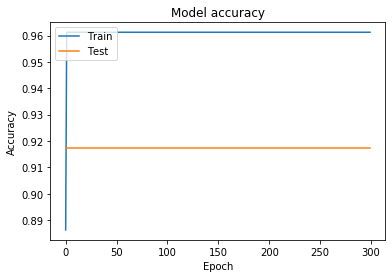

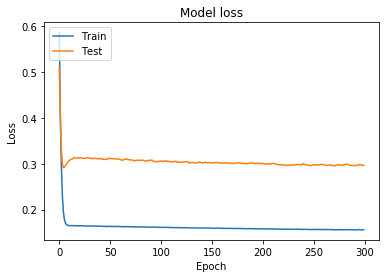

In [22]:

X = df.iloc[:,-10:-1]
Y = df.iloc[:,-1]
print(X)
print(Y)


def create_model_null():
    model = Sequential()
    model.add(Dense(18,input_dim = 9, activation = 'sigmoid'))
    model.add(Dense(1,activation = 'sigmoid'))
    return model


'''
Model just with backpropagation
'''
def BP(X,Y):
    n = create_model_null()
    n.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    history = n.fit(X, Y, validation_split=0.2, epochs=300, batch_size=10, verbose=1, shuffle = True)
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
BP(X,Y)

In [202]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1) 
# 70% training and 30% test
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.952054794520548
